In [207]:
from __future__ import print_function

import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow.keras
import pandas as pd
import numpy as np
import sklearn
import keras
import csv

import keras_uncertainty
from keras_uncertainty.utils import numpy_negative_log_likelihood, numpy_entropy
from keras_uncertainty.layers import DropConnectConv2D, DropConnectDense
from keras_uncertainty.models import MCDropoutClassifier
from keras_uncertainty.utils import numpy_regression_nll

import keras.backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.models import Model, Sequential
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


In [208]:
def load_joint_space_csv_chunks(file_path):
    data_frame = pd.read_csv(file_path, skiprows=1, header=None)
    del data_frame[18]
    #print(data_frame.head(10))
    return data_frame

def load_task_space_csv_chunks(file_path):
    return pd.read_csv(file_path, skiprows=1, header=None)


In [209]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

TRAIN_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/'
TEST_FOLDER = '/home/dfki.uni-bremen.de/bmanickavasakan/newdataset_rh5_leg/leg_5steps/test_4steps'

X_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TRAIN_FILE = os.path.join(TRAIN_FOLDER, 'leg_sysstate_q.csv')

X_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_forwardkinematics_x.csv')
Q_TEST_FILE = os.path.join(TEST_FOLDER, 'leg_sysstate_q.csv')

x_train = load_task_space_csv_chunks(X_TRAIN_FILE)
q_train = load_joint_space_csv_chunks(Q_TRAIN_FILE)

x_test = load_task_space_csv_chunks(X_TEST_FILE)
q_test = load_joint_space_csv_chunks(Q_TEST_FILE)




In [210]:
'''

Standard deviation based data splitting

We consider the Q features and use the feature with the 

highest SD for dividing the dataset
'''

stats_q_train = pd.DataFrame()
stats_q_train["Mean"] = q_train.mean()
stats_q_train["Var"] = q_train.var()
stats_q_train["STD"] = q_train.std()
stats_q_train["OneSigmaMax"] = stats_q_train["Mean"] + stats_q_train["STD"]
stats_q_train["OneSigmaMin"] = stats_q_train["Mean"] - stats_q_train["STD"]
stats_q_train.T

max_std = stats_q_train["STD"].max()
colomn_max_std = stats_q_train["STD"].idxmax()

maximum = stats_q_train.loc[colomn_max_std, "Mean"] + (1.5 * max_std)
minimum = stats_q_train.loc[colomn_max_std, "Mean"] - (1.5 * max_std)
print(maximum, minimum)

InDistribution_Q_Train = q_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_Q_Train = q_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]
InDistribution_X_Train = x_train[q_train[colomn_max_std].le(maximum) & q_train[colomn_max_std].ge(minimum)]
OutDistribution_X_Train = x_train[q_train[colomn_max_std].ge(maximum) | q_train[colomn_max_std].le(minimum)]

InDistribution_Q_Test = q_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_Q_Test = q_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]
InDistribution_X_Test = x_test[q_test[colomn_max_std].le(maximum) & q_test[colomn_max_std].ge(minimum)]
OutDistribution_X_Test = x_test[q_test[colomn_max_std].ge(maximum) | q_test[colomn_max_std].le(minimum)]

x_train_1 = InDistribution_X_Train
q_train_1 = InDistribution_Q_Train
x_test_1 = InDistribution_X_Test
q_test_1 = InDistribution_Q_Test

OOD_x_train = OutDistribution_X_Train
OOD_q_train = OutDistribution_Q_Train
OOD_x_test = OutDistribution_X_Test
OOD_q_test = OutDistribution_Q_Test

print("//////////////////////")
print(x_train_1.shape, OOD_x_train.shape, x_test_1.shape, OOD_x_test.shape)


0.9119140506494964 -0.5558160506494813
//////////////////////
(13750, 9) (1875, 9) (3840, 9) (256, 9)


In [211]:

x_scaler = MinMaxScaler()
q_scaler = MinMaxScaler()

#In order training set
x_train_1 = x_scaler.fit_transform(x_train_1)
q_train_1 = q_scaler.fit_transform(q_train_1)

#complete test set
x_test = x_scaler.transform(x_test)
q_test = q_scaler.transform(q_test)

#split testing data
IOD_x_test = x_scaler.transform(x_test_1)
IOD_q_test = q_scaler.transform(q_test_1)

OOD_x_test = x_scaler.transform(OOD_x_test)
OOD_q_test = q_scaler.transform(OOD_q_test)

In [212]:
dropconnectProb = 0.5

In [213]:
def model_builder(input_shape, output_shape):
    def build_model(depth, width, reduction_factor):
        model = Sequential()
        

        for i in range(depth):
            num_neurons = max(int(width * (reduction_factor ** i)), 4)
            if i == 0:
                model.add(DropConnectDense(num_neurons, activation='relu', input_shape=(input_shape,), prob=dropconnectProb))
            else:
                model.add(DropConnectDense(num_neurons, activation='relu', prob=dropconnectProb))

            model.add(BatchNormalization())
            #num_neurons= num_neurons + 32
            Flatten()

        model.add(DropConnectDense(output_shape, activation='sigmoid', prob=dropconnectProb))
        model.compile(loss='mse', optimizer='adam', metrics=["mae"])

        return model
    return build_model


In [214]:
HYPERPARAMETERS = {'depth': 6, 'width': 64, 'reduction_factor':  0.9}
import tensorflow as tf
with tf.device('/cpu:0'):
    model = model_builder(9, 18)(**HYPERPARAMETERS)
    hist = model.fit(x_train_1, q_train_1, epochs = 100, batch_size = 128, verbose = 1, validation_data=(IOD_x_test, IOD_q_test))
    model.save("ik-rh5-leg-5steps_dropconnect_OOD.h5")

Train on 13750 samples, validate on 3840 samples
Epoch 1/100
13750/13750 [==============================] - 3s 252us/step - loss: 0.1681 - mae: 0.3351 - val_loss: 0.1098 - val_mae: 0.2859
Epoch 2/100
13750/13750 [==============================] - 1s 54us/step - loss: 0.1412 - mae: 0.3085 - val_loss: 0.1080 - val_mae: 0.2828
Epoch 3/100
13750/13750 [==============================] - 1s 54us/step - loss: 0.1233 - mae: 0.2902 - val_loss: 0.1040 - val_mae: 0.2782
Epoch 4/100
13750/13750 [==============================] - 1s 54us/step - loss: 0.1093 - mae: 0.2745 - val_loss: 0.0933 - val_mae: 0.2600
Epoch 5/100
13750/13750 [==============================] - 1s 53us/step - loss: 0.0992 - mae: 0.2617 - val_loss: 0.0868 - val_mae: 0.2444
Epoch 6/100
13750/13750 [==============================] - 1s 53us/step - loss: 0.0934 - mae: 0.2531 - val_loss: 0.0849 - val_mae: 0.2390
Epoch 7/100
13750/13750 [==============================] - 1s 53us/step - loss: 0.0892 - mae: 0.2466 - val_loss: 0.0825 - 

13750/13750 [==============================] - 1s 56us/step - loss: 0.0484 - mae: 0.1709 - val_loss: 0.0531 - val_mae: 0.1789
Epoch 60/100
13750/13750 [==============================] - 1s 54us/step - loss: 0.0493 - mae: 0.1723 - val_loss: 0.0537 - val_mae: 0.1799
Epoch 61/100
13750/13750 [==============================] - 1s 54us/step - loss: 0.0484 - mae: 0.1706 - val_loss: 0.0564 - val_mae: 0.1850
Epoch 62/100
13750/13750 [==============================] - 1s 56us/step - loss: 0.0482 - mae: 0.1702 - val_loss: 0.0487 - val_mae: 0.1714
Epoch 63/100
13750/13750 [==============================] - 1s 55us/step - loss: 0.0479 - mae: 0.1701 - val_loss: 0.0489 - val_mae: 0.1715
Epoch 64/100
13750/13750 [==============================] - 1s 54us/step - loss: 0.0474 - mae: 0.1688 - val_loss: 0.0461 - val_mae: 0.1671
Epoch 65/100
13750/13750 [==============================] - 1s 53us/step - loss: 0.0471 - mae: 0.1685 - val_loss: 0.0444 - val_mae: 0.1638
Epoch 66/100
13750/13750 [==============

In [215]:
epoch  = list(range(0, 200, 1))
#print(epoch)
#print(hist.history['loss'])
# plt.figure()
# plt.plot( epoch, hist.history['loss'],     label = 'Loss')
# plt.plot( epoch, hist.history['mae'],      label = 'MAE')
# plt.plot( epoch, hist.history['val_loss'], label = 'val_loss')
# plt.plot( epoch, hist.history['val_mae'],  label = 'val_mae')
# plt.xlabel("Number of Epochs")
# plt.ylabel("Error")
# plt.legend(loc='upper right')


In [216]:
q_pred = model.predict(x_test, verbose=0)
q_unnorm = q_scaler.inverse_transform(q_test)
q_pred_unnorm = q_scaler.inverse_transform(q_pred)

global_mae = mean_absolute_error(q_test, q_pred)

print("Testing MAE: {:.5f}".format(global_mae))

# Compute MAE for each output independently.
for i in range(q_test.shape[1]):
    norm_mae_i = mean_absolute_error(q_test[:, i], q_pred[:, i])
    mae_i = mean_absolute_error(q_unnorm[:, i], q_pred_unnorm[:, i])
    print("Q feature {} has unnorm MAE: {:.4f} (Range {:.4f} to {:.4f}) normalized MAE: {:.4f}".format(i, mae_i, q_scaler.data_min_[i], q_scaler.data_max_[i], norm_mae_i))



Testing MAE: 0.17410
Q feature 0 has unnorm MAE: 0.3621 (Range -0.7330 to 0.4398) normalized MAE: 0.3087
Q feature 1 has unnorm MAE: 0.2945 (Range -0.3840 to 0.5792) normalized MAE: 0.3057
Q feature 2 has unnorm MAE: 0.0909 (Range -0.8200 to -0.0680) normalized MAE: 0.1209
Q feature 3 has unnorm MAE: 0.0925 (Range -0.8381 to -0.0792) normalized MAE: 0.1219
Q feature 4 has unnorm MAE: 0.0102 (Range 0.0070 to 0.0907) normalized MAE: 0.1219
Q feature 5 has unnorm MAE: 0.0429 (Range 0.0000 to 1.0000) normalized MAE: 0.0429
Q feature 6 has unnorm MAE: 0.0033 (Range -0.0822 to 0.0000) normalized MAE: 0.0401
Q feature 7 has unnorm MAE: 0.0036 (Range 0.0000 to 0.0782) normalized MAE: 0.0458
Q feature 8 has unnorm MAE: 0.2997 (Range -0.7850 to 0.4710) normalized MAE: 0.2386
Q feature 9 has unnorm MAE: 0.1827 (Range -0.7850 to 0.4710) normalized MAE: 0.1455
Q feature 10 has unnorm MAE: 0.3129 (Range -0.5483 to 0.7767) normalized MAE: 0.2362
Q feature 11 has unnorm MAE: 0.3325 (Range -0.5236 to 0

In [217]:
from keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from keras_uncertainty.models import MCDropoutRegressor
from sklearn.preprocessing import MinMaxScaler

def test_mcdropconnect_regressor(x_test_values, q_test_values, model, data_scaler):   
    mc_model = MCDropoutRegressor(model)
    inp = x_test_values  
    
    mean, std = mc_model.predict(inp, num_samples = 10)
    
    q_pred_unnormalised = data_scaler.inverse_transform(mean)
    
    #q_sd_unnromalised = data_scaler.inverse_transform(std)
    
    global_mae = mean_absolute_error(q_test_values, mean)

    print("Testing MAE: {:.5f}".format(global_mae))

    return q_pred_unnormalised, std

mean_1, std_1 = test_mcdropconnect_regressor(x_test, q_test, model, q_scaler)

q_test_unorm = q_scaler.inverse_transform(q_test)

print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_1, std_1**2)))


Testing MAE: 0.31371
NLL: 13.86549


In [218]:
mean_test_IOD, sd_test_IOD = test_mcdropconnect_regressor(IOD_x_test, IOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(IOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_IOD, sd_test_IOD**2)))

Testing MAE: 0.30525
NLL: 14.30626


In [219]:
mean_test_OOD, sd_test_OOD = test_mcdropconnect_regressor(OOD_x_test, OOD_q_test, model, q_scaler)
q_test_unorm = q_scaler.inverse_transform(OOD_q_test)
print("NLL: {:.5f}".format(numpy_regression_nll(q_test_unorm, mean_test_OOD, sd_test_OOD**2)))

Testing MAE: 0.43374
NLL: 18.41770


In [220]:
col_no = 2

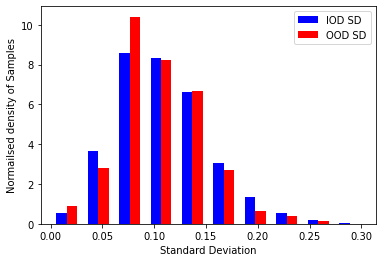

In [221]:
sd_test_IOD_df = pd.DataFrame(sd_test_IOD)
sd_test_OOD_df = pd.DataFrame(sd_test_OOD)
new_scores = np.concatenate([sd_test_IOD_df[col_no], sd_test_OOD_df[col_no]], axis=0)
minmaxscaler = MinMaxScaler()
new_scores_scaled = minmaxscaler.fit_transform(new_scores.reshape(-1, 1))

new_labels = np.concatenate([np.zeros_like(sd_test_IOD_df[col_no]), np.ones_like(sd_test_OOD_df[col_no])], axis=0)
histogram_df = pd.DataFrame(new_scores_scaled, new_labels)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

a_heights, a_bins = np.histogram(sd_test_IOD_df[col_no].values.reshape(-1, 1), density=True)
b_heights, b_bins = np.histogram(sd_test_OOD_df[col_no].values.reshape(-1, 1), bins=a_bins, density=True)

width = (a_bins[1] - a_bins[0])/3

ax.bar(a_bins[:-1], a_heights, width = width, facecolor='blue',label="IOD SD")
ax.bar(b_bins[:-1]+width, b_heights, width = width, facecolor='red', label="OOD SD")
ax.legend()
ax.set_xlabel("Standard Deviation")
ax.set_ylabel("Normailsed density of Samples")
fig.savefig("density_vs_sd_dropconnect_sd_split_col_2.pdf")

0.477294921875


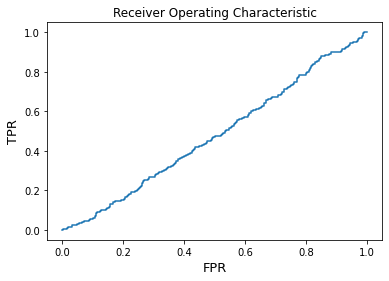

In [224]:
from sklearn.metrics import roc_curve, roc_auc_score

norm_scores = new_scores - min(new_scores) / (max(new_scores) - min(new_scores))

auc = roc_auc_score(new_labels, new_scores)
fpr, tpr, threshs = roc_curve(new_labels, norm_scores, drop_intermediate=True)
print(auc)
plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr)
plt.savefig("auc_dropconnect_sd_split_col_2.pdf")
plt.show()
